# Program 3.05: Proposed model with constant friction

## Preamble

In [ ]:
using NBInclude

In [ ]:
@nbinclude("preamble/packages.ipynb");

In [ ]:
@nbinclude("preamble/functions.ipynb");

In [ ]:
model = ABM(3,

	# Global parameters
	model = Dict(
		# Physical constants
		:range => Float64,
		:lambda => Float64,
		:mu => Float64,
		:adh => Array{Float64},
		# Division constants
		:tau_div => Float64,
		:sigma_div => Float64,
		:olap => Float64,
		:g_on => Bool,
		:d_on => Bool,
		:b => Float64,
		:p => Float64,
		:q => Float64,
		:k => Float64,
		# Noise parameters
		:fp => Float64,
		:kp_on => Float64,
		:kp_off => Float64,
		# Reference values
		:t0 => Float64,
		:r0 => Float64,
		:f0 => Float64,
		:rep => Float64,
	),


	# Local parameters
	agent = Dict(
		:t_div => Float64,
		:ni => Int64,
		:cell_state => Int64,
		# :m=>Float64,               
		:r => Float64,
		:vx => Float64,
		:vy => Float64,
		:vz => Float64,
		:fx => Float64,
		:fy => Float64,
		:fz => Float64,
		:ni_a => Float64,
		:r_ab => Float64,
		:r_bc => Float64,
		# Noise
		:fpx => Float64,
		:fpy => Float64,
		:fpz => Float64,
		:marked => Bool,
		:t_paired => Float64,
	), 
    
    
    agentODE = quote
		# Physical dynamics
		fx = 0
		fy = 0
		fz = 0
		ni = 0
		@loopOverNeighbors it2 begin
			dij = CBMMetrics.euclidean(x, x[it2], y, y[it2], z, z[it2])
			if dij < mu * 2 * r && dij > 0
				if dij < 2 * r
					fx += rep * adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (x - x[it2]) / dij
					fy += rep * adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (y - y[it2]) / dij
					fz += rep * adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (z - z[it2]) / dij
				else
					fx += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (x - x[it2]) / dij
					fy += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (y - y[it2]) / dij
					fz += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (z - z[it2]) / dij
				end
			end
			if dij < range * 2 * r
				ni += 1
			end
		end
		if marked == true
			if t < t_paired
				fx += fpx
				fy += fpy
				fz += fpz
			else
				marked = false
			end
		end
		vx = fx / lambda
		vy = fy / lambda
		vz = fz / lambda
		dt(x) = vx
		dt(y) = vy
		dt(z) = vz
	end, 
    
    
    agentRule = quote
		# Growth
		if g_on
			if t > t_div
				x_div = CBMDistributions.normal(0, 1)
				y_div = CBMDistributions.normal(0, 1)
				z_div = CBMDistributions.normal(0, 1)
				norm_div = sqrt(x_div^2 + y_div^2 + z_div^2)
				x_div /= norm_div
				y_div /= norm_div
				z_div /= norm_div

				r_sep = r * olap
				@addAgent(
					x = x + r_sep * x_div,
					y = y + r_sep * y_div,
					z = z + r_sep * z_div,
					vx = vx / 2,
					vy = vy / 2,
					vz = vz / 2,
					t_div = t + CBMDistributions.uniform(tau_div * (1 - sigma_div), tau_div * (1 + sigma_div))
				)
				@addAgent(
					x = x - r_sep * x_div,
					y = y - r_sep * y_div,
					z = z - r_sep * z_div,
					vx = vx / 2,
					vy = vy / 2,
					vz = vz / 2,
					t_div = t + CBMDistributions.uniform(tau_div * (1 - sigma_div), tau_div * (1 + sigma_div))
				)
				@removeAgent()
			end
		end

		# State evolution
		if d_on == true && cell_state != 3
			ni = 0
			ni_a = 0
			@loopOverNeighbors it2 begin
				dij = CBMMetrics.euclidean(x, x[it2], y, y[it2], z, z[it2])
				if dij < range * 2 * r
					ni += 1
					if (cell_state[it2] == 1)
						ni_a += 1
					end
				end
			end

			if ni != 0
				ni_a /= ni
			end

			ran = CBMDistributions.uniform(0, 1)

			if cell_state == 1
				r_ab = p / (1 + k * ni_a)
				if ran < r_ab * dt
					cell_state = 2
				end

			elseif cell_state == 2
				r_bc = q / (1 + k * ni_a)
				if ran < r_bc * dt
					cell_state = 3
				end
			end
		end

	end, 
    
    
    agentAlg = CBMIntegrators.Heun(),
);


## Initialization

In [ ]:
parameters = define_par(range = 1.2, r = 1);

dt = 0.001;
save_each = round(Int64, 0.25 / dt);
n_cells = 1000;


## Aggregate

In [ ]:
# Random.seed!(2345)
com = initialize_growth(parameters; dt);
com.rep = 2;


In [ ]:
grow_size!(com, save_each, n_cells)
# grow_time!(com,save_each,30)
m0 = length(com);


1001
true
Plot 1: timestamp 1
Plot 2: timestamp 49
Plot 3: timestamp 98
Plot 4: timestamp 146
Plot 5: timestamp 195


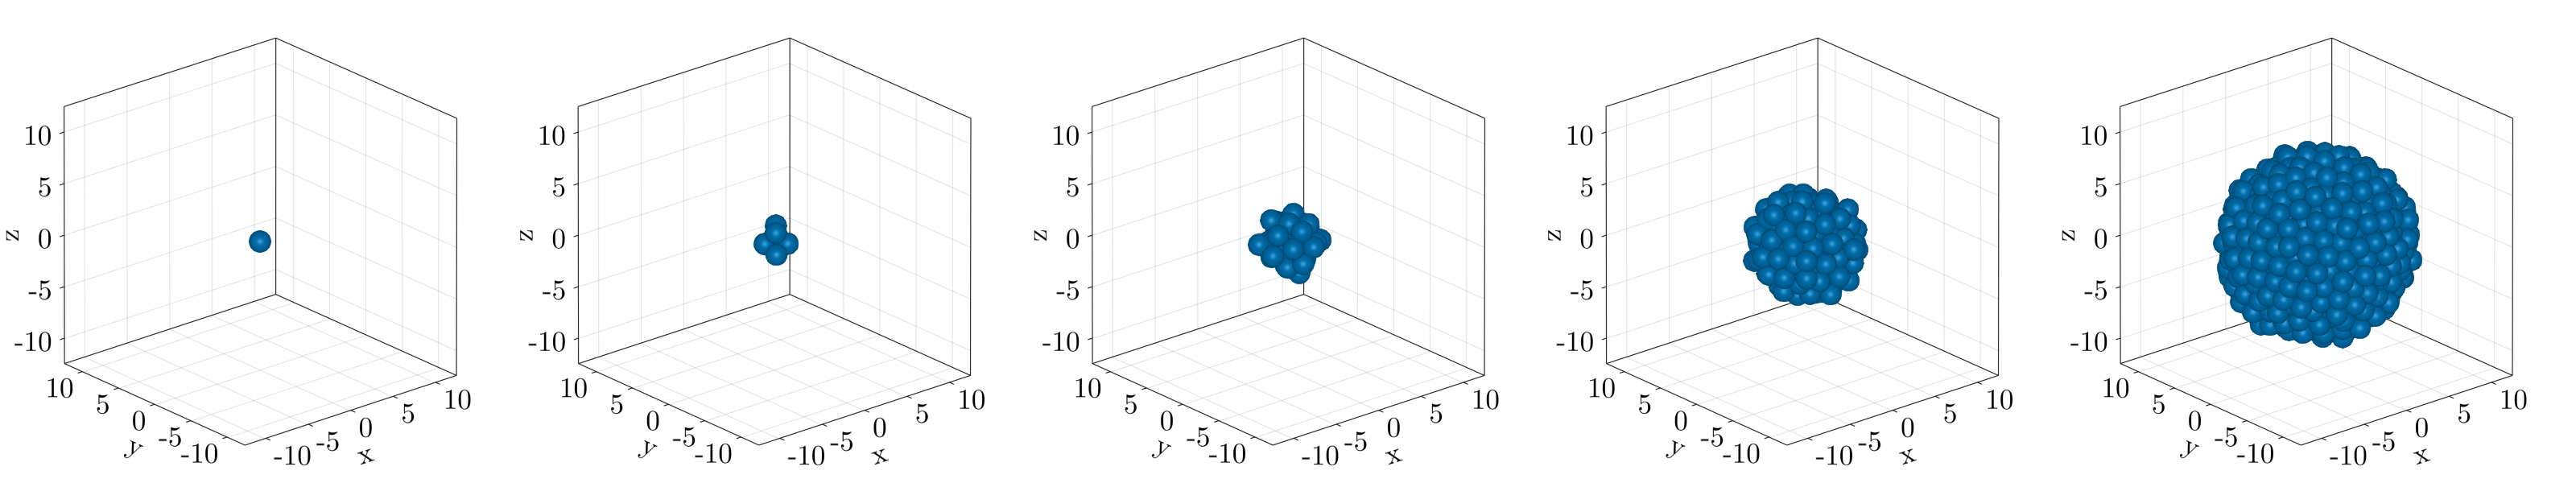

GLMakie.Screen(...)

In [17]:
println(com.N)
println(formed_correctly(com))
plot_aggregate(com, color_map, 1, m0)

In [ ]:
# tmove = 40
# mechanics_evolve!(com,save_each,tmove)
# println(formed_correctly(com))
# plot_aggregate(com, color_map, m0, length(com))

In [ ]:
growncom = deepcopy(com);

## Differentiation

In [ ]:
com = deepcopy(growncom);

com.fp = 20
com.kp_on = 0.7
com.kp_off = 0.4;

In [ ]:
initialize_diff!(com);
# differentiate_all!(com,save_each,prot=false)
# differentiate!(com,save_each,40,prot=false)
differentiate!(com, save_each, 40)
m2 = length(com);


In [ ]:
plot_aggregate(com, color_map, m0, m2)

In [ ]:
# println(minimum(minimum(com[i].ni) for i in (m0+2):m2))
# println(maximum(maximum(com[i].ni) for i in (m0+2):m2))
# println(mean(mean(com[i].ni) for i in (m0+2):m2))
# maximum([maximum(com.x[i] - com.x[j] for j in 1:com.N) for i in 1:com.N])